# Validation Analysis

## Objective
Develop accuracy assessments for tree cover predictions in each country, region, subregion, ecoregion and biome to understand how the model performs differently in each class and determine where we need more data.  
Ultimately we want to be able to say "the error of the model at predicting tree cover was x +/- y at the 95% confidence level". When we report on numbers we will directly reference these confidence intervals.

## Steps
- Start with biomes because they will have tight error bars
- Bootstrap sample n times from each biome
- Calculate precision, recall and F1 scores for each bootstrap
- Calculate 75%, 95%, 99% confidence intervals for the samples
- Repeat for other categories and see what the error bars look like
- Create visualizations to see the error bars (heatmap? examples [here?](https://clauswilke.com/dataviz/visualizing-uncertainty.html))

## Key Questions
- How granular can we make these validation assessments for each region/subregion/ecoregion? 
- Confidence intervals: How confident are we that a certain range around these estimates of tree cover actually contains the true parameter?
- What do the error bars look like for precision, recall and percent error? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [89]:
df = pd.read_csv('../evaluation_joined.csv')
df.columns

Index(['plot_id', 'lat', 'long', 'y', 'error', 'tp', 'fp', 'fn', 'tree_cover',
       'scalerank', 'sovereignt', 'name_alt', 'pop_est', 'gdp_md_est',
       'lastcensus', 'gdp_year', 'economy', 'income_grp', 'un_a3', 'wb_a2',
       'wb_a3', 'woe_id', 'adm0_a3_is', 'continent', 'region_un', 'subregion',
       'region_wb'],
      dtype='object')

## Quick EDA

In [ ]:
#df = pd.read_csv('validation_data_1000.csv')
#df.head()

In [90]:
df['pred'] = df.tp + df.fp
df['true'] = df.tp + df.fn

In [ ]:
df.groupby('LULC')['tp'].sum() / (df.groupby('LULC')['fp'].sum() + df.groupby('LULC')['tp'].sum())

In [ ]:
df.groupby('LULC')['pred'].sum() / df.groupby('LULC')['true'].sum()

In [5]:
df.groupby('tree_class')['pred'].sum() / df.groupby('tree_class')['true'].sum()

KeyError: 'tree_class'

In [73]:
df.subregion.value_counts()

South America                299
Eastern Africa               228
South-Eastern Asia           176
Middle Africa                163
Central America              147
Western Africa               147
Melanesia                     57
Australia and New Zealand     48
Southern Asia                 41
Caribbean                     40
Western Asia                  32
Southern Africa               25
Eastern Asia                   7
Name: subregion, dtype: int64

In [7]:
df.biome.value_counts()

AttributeError: 'DataFrame' object has no attribute 'biome'

In [ ]:
df.tree_class.value_counts(normalize=True)*100

In [ ]:
df.head()

## Bootstrap from each scale, calculate scores and confidence intervals

In [91]:
def bootstrap(df, scale, n):
    
    '''
    Function takes in a df, bootstraps n samples from each category in a scale, 
    calculates scores, then takes percentiles of the bootstrap 
    to calculate confidence intervals and returns 2 dfs with results.
    '''

    # calculation for precision, recall, f1
    def calculate_metrics(tp, fp, fn):
        tp = np.sum(tp)
        fp = np.sum(fp)
        fn = np.sum(fn)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        oe = (tp + fp) / (tp + fn)
        return precision, recall, f1, oe
    
    # get a list of categories within the scale
    categories = set(df[scale].dropna().unique())
    print(f'{scale} has {len(categories)} subcategories. {len(categories)*n} samples in total.')
                     
    # empty df to store samples, scores and CIs
    bootsamples = pd.DataFrame()
    val_df = pd.DataFrame(columns = ['scale', 'category', 'precision', 'recall', 'f1', 'oe'])
    conf_int = pd.DataFrame(columns = ['scale', 'category',
                                       'p_lower_95', 'p_upper_95', 'r_lower_95',
                                       'r_upper_95', 'f1_lower_95','f1_upper_95',
                                       'p_lower_90', 'p_upper_90', 'r_lower_90',
                                       'r_upper_90', 'f1_lower_90','f1_upper_90',
                                       'p_lower_80', 'p_upper_80', 'r_lower_80',
                                       'r_upper_80', 'f1_lower_80','f1_upper_80',
                                       'oe_lower_80', 'oe_upper_80', 'oe_lower_95',
                                      'oe_upper_95'])

    
    # for each category in scale, calculate scores
    for i in categories:
        grouped = df[df[scale] == i]
        
        for num in range(n):   
            bootstrap = grouped.sample(len(grouped), replace = True)
            #bootsamples = bootsamples.append(bootstrap, ignore_index = True)
            precision, recall, f1, oe = calculate_metrics(sum(bootstrap.tp.values), 
                                                      sum(bootstrap.fp.values), 
                                                      sum(bootstrap.fn.values))
            
            # add calculations to empty df
            val_df = val_df.append({'scale': scale, 
                                   'category': i,
                                   'precision': precision,
                                   'recall': recall,
                                   'f1': f1,
                                   'oe': oe}, ignore_index = True)
    
    # use scores in val_df to calculate CIs
    for i in categories:
        grouped2 = val_df[val_df.category == i] 

        # calculate 80, 90, 95th percentile
        p_lower_95, r_lower_95, f1_lower_95, oe_lower_95 = np.percentile(grouped2.precision.values, 2.5),\
                                              np.percentile(grouped2.recall.values, 2.5),\
                                              np.percentile(grouped2.f1.values, 2.5),\
                                              np.percentile(grouped2.oe.values, 2.5)
                                                    
        
        p_upper_95, r_upper_95, f1_upper_95, oe_upper_95 = np.percentile(grouped2.precision.values, 97.5),\
                                              np.percentile(grouped2.recall.values, 97.5),\
                                              np.percentile(grouped2.f1.values, 97.5),\
                                                           np.percentile(grouped2.oe.values, 97.5)
                

        p_lower_90, r_lower_90, f1_lower_90, oe_lower_90 = np.percentile(grouped2.precision.values, 5),\
                                              np.percentile(grouped2.recall.values, 5),\
                                              np.percentile(grouped2.f1.values, 5),\
                                                           np.percentile(grouped2.oe.values, 5,) 
                                                            
        p_upper_90, r_upper_90, f1_upper_90, oe_upper_90 = np.percentile(grouped2.precision.values, 95),\
                                              np.percentile(grouped2.recall.values, 95),\
                                              np.percentile(grouped2.f1.values, 95),\
                                                           np.percentile(grouped2.oe.values, 95)
        

        p_lower_80, r_lower_80, f1_lower_80, oe_lower_90 = np.percentile(grouped2.precision.values, 10),\
                                              np.percentile(grouped2.recall.values, 10),\
                                              np.percentile(grouped2.f1.values, 10),\
                                                           np.percentile(grouped2.oe.values, 10) 
                                                            
        p_upper_80, r_upper_80, f1_upper_80, oe_upper_80 = np.percentile(grouped2.precision.values, 90),\
                                              np.percentile(grouped2.recall.values, 90),\
                                              np.percentile(grouped2.f1.values, 90),\
                                                           np.percentile(grouped2.oe.values, 90)
        
        
        
        # add percentiles to empty df
        conf_int = conf_int.append({'scale': scale, 
                                    'category': i,
                                   'p_lower_95': p_lower_95, 
                                   'p_upper_95': p_upper_95, 
                                   'r_lower_95': r_lower_95,
                                   'r_upper_95': r_upper_95, 
                                   'f1_lower_95': f1_lower_95,
                                   'f1_upper_95': f1_upper_95,
                                   'p_lower_90': p_lower_90, 
                                   'p_upper_90': p_upper_90, 
                                   'r_lower_90': r_lower_90,
                                   'r_upper_90': r_upper_90, 
                                   'f1_lower_90': f1_lower_90,
                                   'f1_upper_90': f1_upper_90,
                                   'p_lower_80': p_lower_80, 
                                   'p_upper_80': p_upper_80, 
                                   'r_lower_80': r_lower_80,
                                   'r_upper_80': r_upper_80, 
                                   'f1_lower_80': f1_lower_80,
                                   'f1_upper_80': f1_upper_80,
                                   'oe_upper_95': oe_upper_95,
                                   'oe_lower_95': oe_lower_95}, ignore_index = True)

    # returns scores and conf intervals separately
    return val_df, conf_int

In [92]:
lc_val, lc_conf = bootstrap(df, 'LULC', 200)

KeyError: 'LULC'

In [ ]:
lc_conf

In [11]:
biome_val, biome_conf = bootstrap(df, 'region_un', 200)

region_un has 5 subcategories. 1000 samples in total.


In [93]:
subregion_val, subregion_conf = bootstrap(df, 'subregion', 1000)

subregion has 13 subcategories. 13000 samples in total.


In [ ]:
country_val, country_conf = bootstrap(df, 'country', 100)

In [ ]:
country_val[country_val.category == 'Ethiopia'].head()

In [ ]:
ethiopia = country_conf[country_conf.category == 'Ethiopia']
ethiopia

In [ ]:
country_conf[:10]

## Visualizations

In [94]:
def visualize_precision(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'lightsteelblue', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'royalblue', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['p_lower_80'],
                               conf_int_df['p_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Precision Confidence Intervals for {title}');
    
    return None

In [95]:
def visualize_recall(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'darkseagreen', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'seagreen', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['r_lower_80'],
                               conf_int_df['r_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Recall Confidence Intervals for {title}');
    
    return None

In [96]:
def visualize_f1(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'thistle', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'darkslateblue', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_80'],
                               conf_int_df['f1_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'F1 Confidence Intervals for {title}')
    
    return None

### Biome

In [ ]:
visualize_precision(biome_conf, 6, (13,6), 'Region')
visualize_recall(biome_conf, 6, (13,6), 'Region')
visualize_f1(biome_conf, 6, (13,6), 'Region')

### Subregion

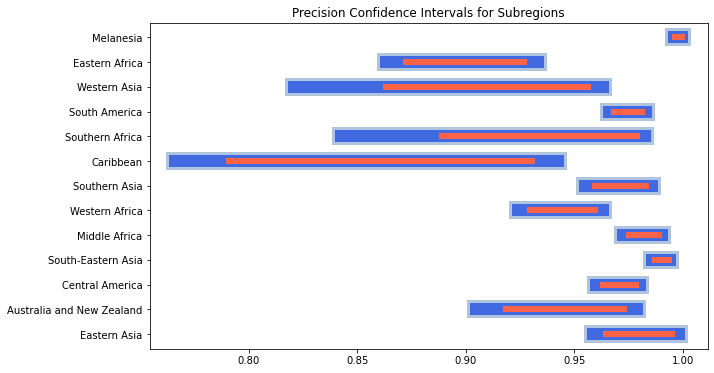

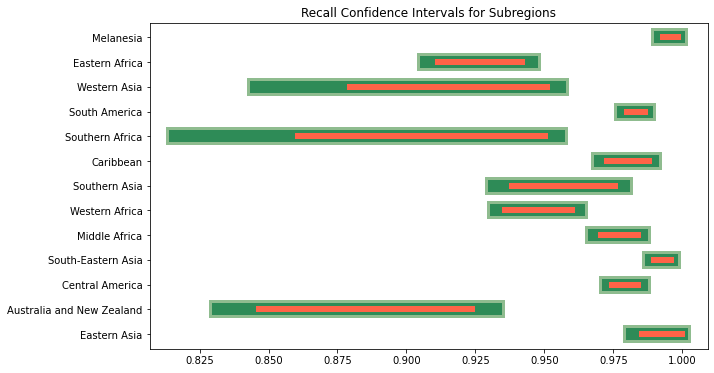

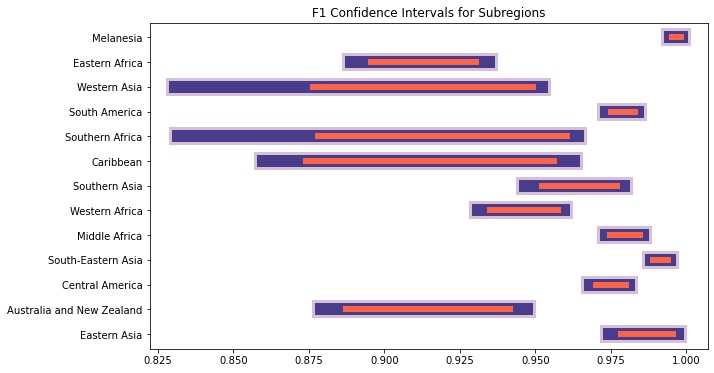

In [97]:
visualize_precision(subregion_conf, 6, (10,6), 'Subregions')
visualize_recall(subregion_conf, 6, (10,6), 'Subregions')
visualize_f1(subregion_conf, 6, (10,6), 'Subregions')

In [ ]:
visualize_precision(lc_conf, 6, (10,6), 'LULC')
visualize_recall(lc_conf, 6, (10,6), 'LULC')
visualize_f1(lc_conf, 6, (10,6), 'LULC')

### Country Examples

In [ ]:
visualize_precision(country_conf[:10], 6, (13,6), 'Sample Countries')
visualize_recall(country_conf[:10], 6, (13,6), 'Sample Countries')
visualize_f1(country_conf[:10], 6, (13,6), 'Sample Countries')